In [1]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from lc_classifier.utils import plot_astro_object
from lc_classifier.features.core.base import AstroObject
from lc_classifier.features.extractors.period_extractor import PeriodExtractor
from typing import List

In [2]:
!ls data_231130/ | grep '.pkl' | head

astro_objects_batch_0000.pkl
astro_objects_batch_0001.pkl
astro_objects_batch_0002.pkl
astro_objects_batch_0003.pkl
astro_objects_batch_0004.pkl
astro_objects_batch_0005.pkl
astro_objects_batch_0006.pkl
astro_objects_batch_0007.pkl
astro_objects_batch_0008.pkl
astro_objects_batch_0009.pkl


In [67]:
selected_aid = 'aid_ZTF18accldzb'

data_dir = os.listdir('data_231130')
data_dir = [filename for filename in data_dir if 'astro_objects_batch' in filename]
data_dir = sorted(data_dir)

for batch_filename in tqdm(data_dir):
    full_filename = os.path.join('data_231130', batch_filename)
    astro_objects_batch = pd.read_pickle(full_filename)
    for astro_object in astro_objects_batch:
        astro_object_aid = astro_object.metadata[astro_object.metadata['name'] == 'aid']['value'].values[0]
        if astro_object_aid == selected_aid:
            print(astro_object)
            break
    if astro_object_aid == selected_aid:
        print('exit')
        break

 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                           | 99/188 [00:14<00:12,  7.06it/s]

AstroObject(metadata=  name             value
0  aid  aid_ZTF18accldzb
1  oid      ZTF18accldzb, detections=              candid  brightness  e_brightness fid           mjd  detected  \
oid                                                                          
ZTF18accldzb       2   55.539971      6.777239   r  58303.468082      True   
ZTF18accldzb       4   63.607359      3.752713   r  58316.466774      True   
ZTF18accldzb       5 -247.710582      3.292465   r  58319.470224      True   
ZTF18accldzb       8   65.321545      6.057425   r  58325.482877      True   
ZTF18accldzb      10   60.020117      4.626813   r  58334.442842      True   
...              ...         ...           ...  ..           ...       ...   
ZTF18accldzb     935   17.942078      0.019570   r  59409.471858      True   
ZTF18accldzb     936   17.865959      0.019601   r  59409.474300      True   
ZTF18accldzb     938   16.953372      0.005701   r  59434.466444      True   
ZTF18accldzb     940   16.927015  

In [4]:
object_info = pd.read_parquet('data_231130/objects_231130.parquet')
object_info

,ra,dec,submitter,alerceclass
oid,,,,
ZTF18aaadfyl,156.578799,18.586220,amunoz,RSCVn
ZTF21aaiaqhh,193.878339,30.027998,amunoz,SNII
ZTF21aapjqdl,206.288918,-10.600883,amunoz,SNIa
ZTF18aalozvy,149.874570,21.389226,amunoz,Blazar
ZTF18abcjabg,283.041552,-3.028178,amunoz,CEP
...,...,...,...,...
ZTF23aaqniyk,266.581282,10.106150,amunoz,SNII
ZTF19abpfljz,16.164184,38.590284,amunoz,QSO
ZTF19aayepvi,243.831109,-25.670230,amunoz,YSO


In [5]:
object_info['alerceclass'].unique()

array(['RSCVn', 'SNII', 'SNIa', 'Blazar', 'CEP', 'YSO', 'CVNova', 'DSCT',
       'Periodic-Other', 'SNIIn', 'QSO', 'EA', 'AGN', 'LPV', 'EBEW',
       'SNIbc', 'RRLc', 'RRLab', 'Microlensing', 'SLSN', 'SNIIb', 'TDE'],
      dtype=object)

In [52]:
object_index =  51
astro_object = astro_objects[object_index]
metadata = astro_object.metadata
oid = metadata[metadata['name'] == 'oid']['value'].values[0]
object_info.loc[oid]

ra               5.62653
dec            64.810917
submitter         amunoz
alerceclass          CEP
Name: ZTF17aaaedyv, dtype: object

In [68]:
object_info.loc[selected_aid.split('_')[1]]

ra             54.215578
dec            36.247321
submitter         amunoz
alerceclass           EA
Name: ZTF18accldzb, dtype: object

In [69]:
period = astro_object.features.set_index('name').loc['Multiband_period'].value
period

2.2083423114229337

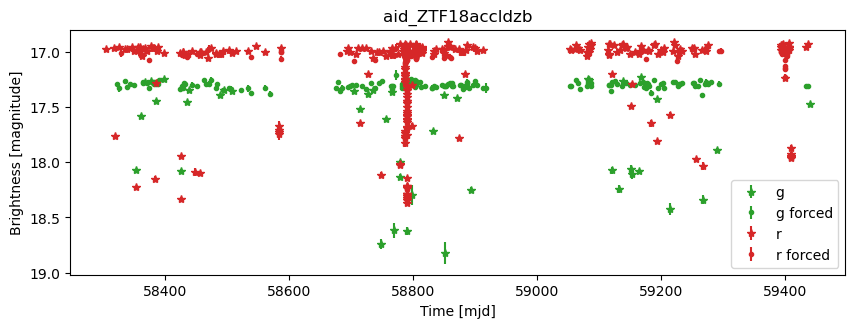

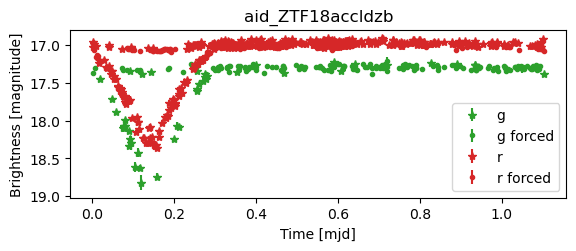

<Figure size 640x480 with 0 Axes>

In [78]:
plt.figure(figsize=(10, 7))
plt.subplot(2, 1, 1)
plot_astro_object(astro_object, unit='magnitude', use_forced_phot=True)
plt.subplot(2, 1, 2)
plot_astro_object(astro_object, unit='magnitude', use_forced_phot=True, period=1.103257)
plt.tight_layout()

In [75]:
bands = list('gr')
period_extractor = PeriodExtractor(
    bands,
    unit='magnitude',
    smallest_period=0.045,
    largest_period=100.0,
    trim_lightcurve_to_n_days=1000.0,
    min_length=15,
    use_forced_photo=True,
    return_power_rates=True,
    shift=0.1
)

In [76]:
period_extractor.compute_features_single_object(astro_object)

In [77]:
astro_object.features.set_index('name').loc['Multiband_period']

,value,fid,sid,version
name,,,,
Multiband_period,2.208342,"g,r",ztf,1.0.0
Multiband_period,1.103266,"g,r",ztf,1.0.0
Multiband_period,1.103257,"g,r",ztf,1.0.0


In [25]:
def all_features_from_astro_objects(astro_objects: List[AstroObject]) -> pd.DataFrame:
    first_object = astro_objects[0]
    features = first_object.features.drop_duplicates(subset=['name', 'fid'])
    features = features.set_index(['name', 'fid'])
    indexes = features.index.values
    
    feature_list = []
    oids = []
    for astro_object in astro_objects:
        features = astro_object.features.drop_duplicates(subset=['name', 'fid'])
        features = features.set_index(['name', 'fid'])
        feature_list.append(features.loc[indexes]['value'].values)
        
        metadata = astro_object.metadata
        oid = metadata[metadata['name'] == 'oid']['value'].values[0]
        oids.append(oid)
    
    df = pd.DataFrame(
        data=np.stack(feature_list, axis=0),
        index=oids,
        columns=['_'.join([str(i) for i in pair]) for pair in indexes]
    )
    return df

In [27]:
astro_objects = pd.read_pickle('data_231130/astro_objects_batch_0000.pkl')
features_df = all_features_from_astro_objects(astro_objects)
features_df

,"g-r_mean_g,r","g-r_max_g,r",MHPS_ratio_g,MHPS_low_g,MHPS_high_g,MHPS_non_zero_g,MHPS_PN_flag_g,MHPS_ratio_r,MHPS_low_r,MHPS_high_r,...,last_brightness_before_band_r,max_brightness_before_band_r,median_brightness_before_band_r,n_forced_phot_band_after_r,max_brightness_after_band_r,median_brightness_after_band_r,Timespan_nan,Coordinate_x_nan,Coordinate_y_nan,Coordinate_z_nan
ZTF17aaaaajz,3.606684,3.822370,30.711777,7.742205e-01,0.025209,16.0,0.0,175.091080,6.968954,0.039802,...,NaN,NaN,NaN,30.0,14.045668,-21.270028,1112.001285,0.313545,0.544991,0.777608
ZTF17aaaaauo,2.866425,3.132062,61.113964,7.562989e-01,0.012375,91.0,0.0,415.129730,31.327026,0.075463,...,NaN,NaN,NaN,335.0,38.115958,-17.470143,1211.863932,0.512471,-0.383321,0.768400
ZTF17aaaabte,0.400895,0.314832,6.490030,1.238626e+01,1.908505,350.0,0.0,4.810787,13.221408,2.748284,...,NaN,NaN,NaN,8.0,23.676932,12.574368,1149.960250,0.735010,0.388589,0.555661
ZTF17aaaactd,2.424023,2.139564,11.487591,3.325856e+02,28.951729,55.0,0.0,3.714489,57.510006,15.482615,...,NaN,NaN,NaN,18.0,48.614857,-7.034458,941.691661,0.058632,0.998279,0.000834
ZTF17aaaactj,0.429526,0.422517,2.815125,1.295501e+01,4.601929,231.0,0.0,2.369968,41.278934,17.417503,...,-26.374397,-26.374397,-45.43075,106.0,86.391663,2.359485,1132.989627,0.649265,0.466368,0.600796
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF17aaadzce,3.302590,3.112220,572.060181,1.626767e+07,28436.990234,249.0,0.0,694.115417,2320.278320,3.342785,...,NaN,NaN,NaN,12.0,21.056934,-7.021806,1212.893555,0.486546,-0.522748,0.700006
ZTF17aaadzcj,2.051862,1.840399,2.158851,5.279055e+02,244.530716,279.0,0.0,1.579714,954.759094,604.387146,...,NaN,NaN,NaN,23.0,21.890853,-4.664115,1212.893565,0.486421,-0.524849,0.698519
ZTF17aaadzee,3.634099,3.399016,135.515701,2.397030e+00,0.017688,237.0,0.0,483.066925,5.131762,0.010623,...,NaN,NaN,NaN,7.0,27.781862,6.981458,1217.758916,0.437350,-0.565904,0.698912
ZTF17aaadzhc,2.258741,3.379089,771.852295,8.116357e+01,0.105154,367.0,0.0,962.918335,102.770966,0.106729,...,NaN,NaN,NaN,6.0,3.719584,-2.944597,1228.796910,0.416297,-0.532500,0.736981


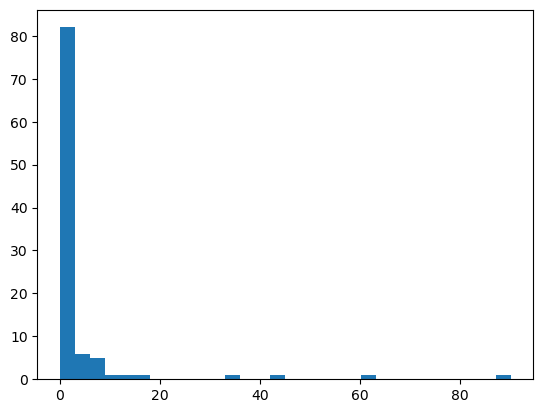

In [28]:
plt.hist(features_df['Multiband_period_g,r'].values, bins=30);

In [29]:
labels_batch = object_info.loc[features_df.index]
for alerceclass in ['DSCT', 'RRLab', 'RRLc', 'EBEW', 'EA', 'CEP']:
    oids_class = labels_batch[labels_batch['alerceclass'] == alerceclass].index.values
    print(alerceclass, features_df.loc[oids_class]['Multiband_period_g,r'].describe())

DSCT count    2.000000
mean     0.079852
std      0.029088
min      0.059284
25%      0.069568
50%      0.079852
75%      0.090137
max      0.100421
Name: Multiband_period_g,r, dtype: float64
RRLab count    10.000000
mean      0.500543
std       0.056038
min       0.371709
25%       0.478907
50%       0.516837
75%       0.525392
max       0.575132
Name: Multiband_period_g,r, dtype: float64
RRLc count    5.000000
mean     0.330043
std      0.062160
min      0.236553
25%      0.319196
50%      0.320802
75%      0.381267
max      0.392400
Name: Multiband_period_g,r, dtype: float64
EBEW count    12.000000
mean      0.199072
std       0.086058
min       0.123461
25%       0.150370
50%       0.166434
75%       0.199909
max       0.396590
Name: Multiband_period_g,r, dtype: float64
EA count    8.000000
mean     0.572699
std      0.305049
min      0.212918
25%      0.406474
50%      0.507733
75%      0.638459
max      1.150551
Name: Multiband_period_g,r, dtype: float64
CEP count    18.000000
me